#  <font color = 545AA7> Bond Angles and Ramachandran Plots </font>

In this Jupyter notebook, you will be introduced to measuring the **angles** and **dihedral angles** along the backbond of peptide chains. The goals of this notebook are to:
- Measure angles and dihedral angles using biopython
- Examine angle distributions using histogram plots
- Generate Ramachandran plots by multiple plotting methods

**Dihedral angles** are torsional angles formed by four adjacent atoms. There are three types of dihedral angles along the peptide backbond designated wiht phi ($\phi$), psi ($\psi$), and omega ($\omega$) as shown below. These angles typically fall within specific ranges due to steric repulsion and bond order. In this notebook, we will explore these typical ranges.

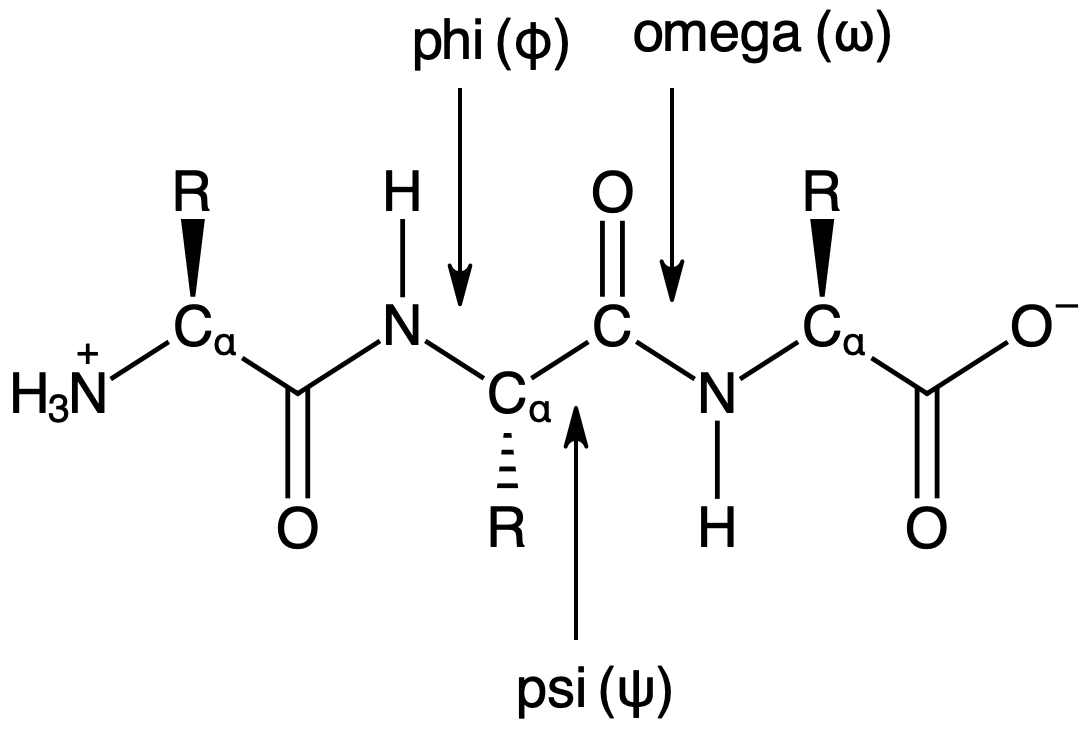

In [1]:
from IPython.display import Image
Image("tripeptide.png", width=400)

## <font color = F28500> Big question: What are the trends in bond angles in proteins? </font>

In [2]:
import Bio.PDB
from Bio.PDB.vectors import calc_dihedral, calc_angle

import matplotlib.pyplot as plt
%matplotlib inline
import os

import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

## <font color = 545AA7> 1. Measure Single Peptide Angles </font>

The `Bio.PDB.vectors` module of biopython contains two functions called `calc_angle()` and `calc_dihedral()` for calculating conventional angles or dihedral angles, respecitely, along the backbond of a peptide. These function take the vector coordinates (xyz) of the three or four atoms that define the angle or dihedral angle.

~~~python
calc_angle(<vector>, <vector>, <vector>)

calc_dihedral(<vector>, <vector>, <vector>, <vector>)
~~~

The vectors can be otained from the residues using the `get_vector()` function.

For example, let's say we want to know the C-N-C$_\alpha$ angle. The first block of code loads a PDB file and grabs the first amino acid residue of the first chain of the 6x8j.pdb structure. 

### <font color = F28500> Be sure to run this code cell! </font>

In [3]:
parser = Bio.PDB.PDBParser()
structure = parser.get_structure('6x8j', '6x8j.pdb')

chain_A = structure[0]['A']
res = chain_A[58]

Next, we will obtain the coordinate vectors for the carbon, nitrogen, and $\alpha$-carbon of an amino acid residue and attach them to variables `N`, `CA`, and `C`, respectively. This is done by identifying the specific atom and using the `get_vector()` function as described in the previous Jupyter notebook.

Finally, these three vectors are fed into the `calc_angle()` function which returns the angle in radians.

In [4]:
C = res['C'].get_vector()
N = res['N'].get_vector()
CA = res['CA'].get_vector()

ang = calc_angle(N, CA, C)
ang

1.9625051493089707

### <font color = F28500> Practice: Find Angle in Degrees </font>

Copy and paste the code from the above code cell and modify it to find the angle of the C$_\alpha$-C-O bond. The oxygen in the aminoacid residue is designated by `['O']`.

If you have time, convert the output from radiants $\rightarrow$ degrees. 

$$ degrees = radians \times \frac{180}{\pi} $$

In [5]:
C = res['C'].get_vector()
CA = res['CA'].get_vector()
O = res['O'].get_vector()

ang = calc_angle(CA, C, O)
ang

2.086180584850502

In [6]:
ang * (180 / 3.14)

119.58996983219437

## <font color = 545AA7> 2. Examine Distributions of Angles </font>

Let's now examine the distribution of the omega ($\omega$) bond angles using a histogram plot. In the code cell below, there is code that defines the Python function `get_omega()` you can use to measure all the omega dihedral angles.

### <font color = F28500> Run the pre-written code in the following cell. </font>

In [7]:
# Run this cell to define a function you can use in subsequent cells

def get_abs_omega(file):
    """Return list of absolute value omega dihedral angles in radians"""  
    omega_list = []
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure('protein', file)
    pp = Bio.PDB.PPBuilder().build_peptides(structure[0])
    for chain in pp:
        for res in range(0, len(chain) - 1):
            try:
                # get vectors for this peptide and the N from the subsequent peptide
                CA = chain[res]['CA'].get_vector()
                C = chain[res]['C'].get_vector()
                N_next = chain[res + 1]['N'].get_vector()
                C_next = chain[res + 1]['CA'].get_vector()
                omega = calc_dihedral(CA, C, N_next, C_next) * (180 / 3.14159)
                omega_list.append(abs(omega))
            except KeyError:
                continue
    return omega_list

Now you will use the function in the following cell. Place the name of a PDB file in quotes inside the parentheses, and the function will return a list of omega dihedral angles in degrees.

Example: 
~~~python
get_abs_omega('5grt.pdb')
~~~



### <font color = F28500> Practice: Plot Omega Angle Distribution </font>

1. Run the `get_abs_omega()` function below for the **6x8j.pdb** protein. You will also want to assign this list of angles to a variable for later use.
2. Plot the distribution of omega angles using the `plt.hist()` histogram plot function. See the first Jupyter notebook if you need review.
3. What do you notice about the distribution? What is the strucutral reason for this? Write you answer in a markdown cell below. *Hint: the omega angle is centered on the peptide amide bond.*

In [8]:
omega = get_abs_omega('6x8j.pdb')

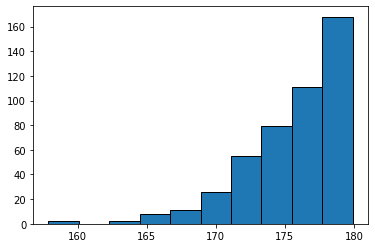

In [9]:
plt.hist(omega, bins=10, edgecolor='black')
plt.show()

In [10]:
omega = []

import os
path, _ = os.path.split(os.getcwd())
top80 = os.path.join(path, 'Top80')

for file in os.listdir(top80):
    if file.endswith('pdb'):
        omega.extend(get_abs_omega(os.path.join(top80,file)))

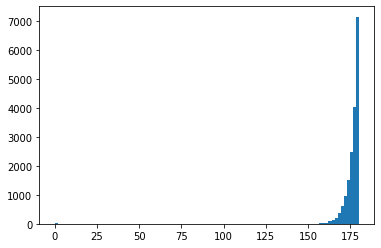

In [11]:
plt.hist(omega, bins=100)
plt.show()

## <font color = 545AA7> 3. Ramachandran Plots from Single Protein </font>

A **Ramachandran plot** is a 2D plot of the psi ($\psi$) versus the phi ($phi$) dihedral angles. Below is a function that takes the file name of a PDB file and returns two lists: a list of phi and and list of psi angles.

e.g.,  `ramachandran('1abc.pdb')` -> `[phi], [psi]`

In [12]:
def ramachandran(PDB):
    """Accepts a PDB file name (string) and returns two lists of phi 
    and psi angles, respectively.
    """
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure('protein', PDB)
    polypeptide = Bio.PDB.PPBuilder().build_peptides(structure[0])
    
    phi = []
    psi = []

    for strand in polypeptide:
        phipsi = strand.get_phi_psi_list()
        for point in phipsi:
            try:
                phi_point = point[0] * (180 / 3.14159)
                psi_point = point[1] * (180 / 3.14159)
                phi.append(phi_point)
                psi.append(psi_point)
            except TypeError:
                pass
    
    return phi, psi

Let's run the `ramachandran` function with a single **6x8j.pdb** protein file and plot the result in a `scatter(x,y)` plot.

Text(0, 0.5, 'psi $\\psi$, degrees')

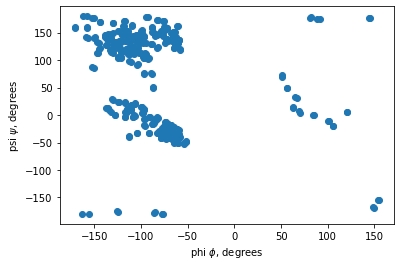

In [13]:
phi, psi = ramachandran('6x8j.pdb')

plt.scatter(phi, psi)
plt.xlabel('phi $\phi$, degrees')
plt.ylabel('psi $\psi$, degrees')

## <font color = 545AA7> 4. Ramachandran Plots from Multiple Top8000 Proteins </font>

We will now collect data on a larger number of PDB files and plot the result. You have been provided a folder containing a few PDB files from the Top8000 dataset. Calculating the phi and psi angles for all 8000 often requires at least a few minutes of computer time, so for the sake of time, we will only work with a subset of this dataset. You can download the full dataset from [http://kinemage.biochem.duke.edu/databases/top8000.php](http://kinemage.biochem.duke.edu/databases/top8000.php) if you wish to use the full dataset *at a later date*.

In [14]:
import os
path, _ = os.path.split(os.getcwd())
top80 = os.path.join(path, 'Top80')

In [15]:
phi_list = []
psi_list = []

for file in os.listdir(top80):
    if file.endswith('pdb'):
        phi, psi = ramachandran(os.path.join(top80,file))
        phi_list.extend(phi)
        psi_list.extend(psi)

Text(0, 0.5, 'psi $\\psi$, degrees')

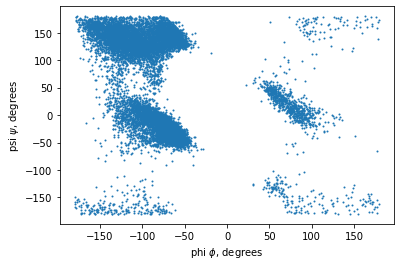

In [16]:
plt.scatter(phi_list, psi_list, s=1)
plt.xlabel('phi $\phi$, degrees')
plt.ylabel('psi $\psi$, degrees')

### <font color = 545AA7> Other Plotting Representations </font>

One issue with the scatter plot above is that it's difficult to see any features inside the two large regions on the left side. Once there is a critical mass of dots in the scatter plot, it's just a solid color. There are other plotting libraries and functions available to help. Along with the popular matplotlib library, there is the [seaborn](https://seaborn.pydata.org/) Python plotting library that includes a selection of relatively simple to use plotting functions that can help.

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Text(0, 0.5, 'psi $\\psi$, degrees')

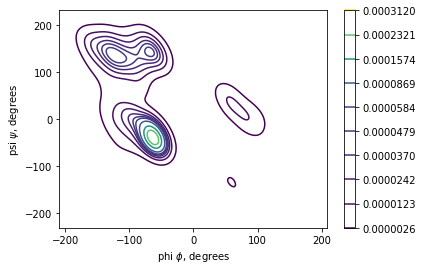

In [17]:
import seaborn as sns
sns.kdeplot(x=phi_list, y=psi_list, cbar=True, cmap='viridis')
plt.xlabel('phi $\phi$, degrees')
plt.ylabel('psi $\psi$, degrees')

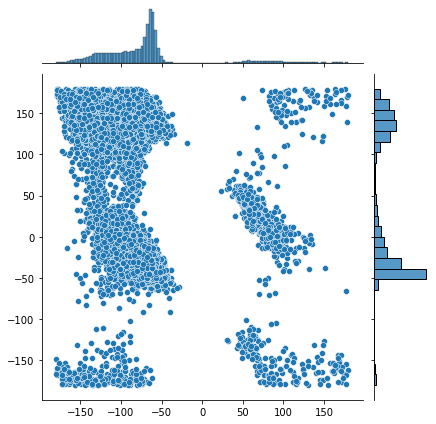

In [18]:
sns.jointplot(x=phi_list, y=psi_list)

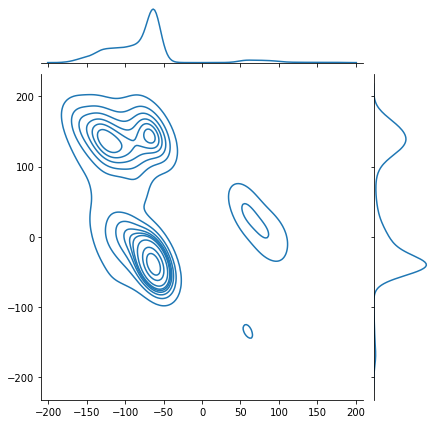

In [19]:
sns.jointplot(x=phi_list, y=psi_list, kind='kde')

### <font color = F28500> Practice: Plotting Ramachandrans Plots with Secondary Structure </font>

For a little extra practice, let's visualize how the presencen of helix and sheet **secondary structures** affects the phi and psi angles. Run the following two code cells to harvest a the phi and psi angles from your 80 protein dataset, but this time, it will also record if each amino acid residue is unstructured, in a helix, or in a sheet. *Note: helicies in this dataset are a mixture of $\alpha$-helicies or $3_{10}$-helicies*

In [20]:
def get_secondary_list(file):
    '''(string) -> ([list], [list])
    
    Accepts a PDB file name (string) and returns two lists of residues
    contained inside helicies and sheets, respetively. The residues are
    strings containing the chain identifies and residue number
    
    >>> ('1abc.pdb') -> [['A34', 'A35', 'A36'], ['A74', 'A75', 'A93', 'A94']] 
    '''
    
    alpha = []
    three_ten = []
    sheets = []
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('HELIX'):
                chain = line[19:20]
                start = line[21:25].strip()
                stop = line[33:37].strip()
                
                if line[39:40] == '1':
                    for res in range(int(start), int(stop) + 1):
                        alpha.append(chain + str(res))
                if line[39:40] == '5':
                    for res in range(int(start), int(stop) + 1):
                        three_ten.append(chain + str(res))
                    
            if line.startswith('SHEET'):
                chain = line[21:22]
                start = line[22:26].strip()
                stop = line[33:37].strip()
                
                for res in range(int(start), int(stop) + 1):
                    sheets.append(chain + str(res))
                    
    return alpha, three_ten, sheets

def get_phi_psi_sec_list(file):
    """Return list of absolute value omega dihedral angles in radians""" 
    
    alpha, three_ten, beta = get_secondary_list(file)
    
    phi_psi_structure = []
    
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure('protein', file)
    
    for chain in structure[0]:
        # get chain ID and residue numbers
        ID = chain.get_id()
        seq_ID = [residue.get_id()[1] for residue in chain]
        
        pp = Bio.PDB.PPBuilder().build_peptides(chain)[0]
        
        for res in range(1, len(pp) - 1):
            res_ID = ID + str(seq_ID[res])
            #print(res_ID)
            try:
                # get vectors for this peptide and the N from the subsequent peptide
                
                C_prev = pp[res - 1]['C'].get_vector()
                CA = pp[res]['CA'].get_vector()
                C = pp[res]['C'].get_vector()
                N = pp[res]['N'].get_vector()
                N_next = pp[res + 1]['N'].get_vector()
                phi = calc_dihedral(C_prev, N, CA, C) * (180 / 3.14159)
                psi = calc_dihedral(N, CA,C, N_next) * (180 / 3.14159)
    
                if res_ID in alpha:
                    structure = 'alpha-helix'
                elif res_ID in three_ten:
                    structure = 'three_ten-helix'
                elif res_ID in beta:
                    structure = 'sheet'
                else:
                    structure = 'unstructured'
                    
                phi_psi_structure.append([phi, psi, structure])

                
            except KeyError:
                print('Key Error!')
                
        return phi_psi_structure

In [21]:
phi_psi_sec = []

path, _ = os.path.split(os.getcwd())
top80 = os.path.join(path, 'Top80')

for file in os.listdir(top80):
    if file.endswith('pdb'):
        phi_psi_sec.extend(get_phi_psi_sec_list(os.path.join(top80,file)))       

In [22]:
import pandas as pd
df = pd.DataFrame(data=phi_psi_sec, columns=['phi','psi', 'structure'])
df

,phi,psi,structure
0,-68.530484,125.694719,unstructured
1,80.751198,-9.201992,unstructured
2,-86.457910,125.645406,unstructured
3,-92.169453,124.810233,sheet
4,-92.425998,124.451491,sheet
...,...,...,...
10701,-156.491897,154.145583,sheet
10702,-81.622179,131.701232,sheet
10703,-135.036157,159.961719,sheet
10704,-123.924712,148.635385,sheet


Now let's plot the data using the **seaborn** plotting library which contains an assortment of ploting functions that produce more complex plots with relatively few lines of code.



<AxesSubplot:xlabel='phi', ylabel='psi'>

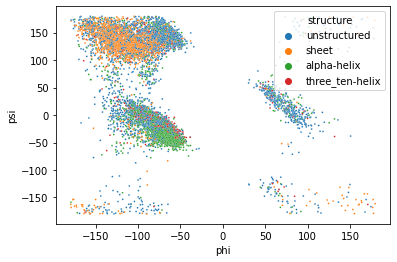

In [23]:
sns.scatterplot(x=df['phi'], y=df['psi'], hue=df['structure'], s=3)

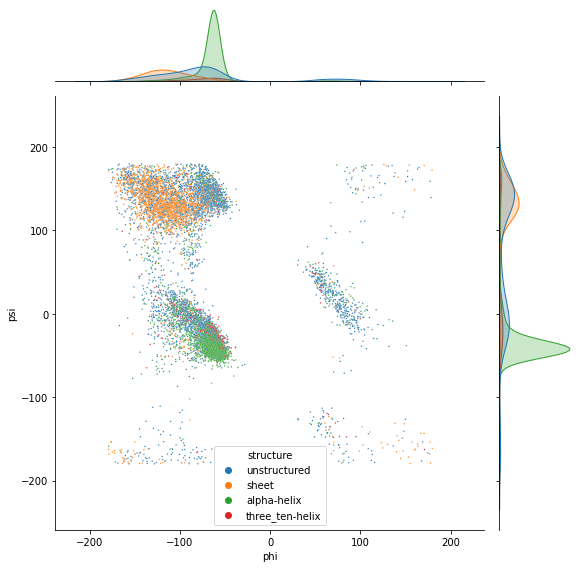

In [24]:
sns.jointplot(x=df['phi'], y=df['psi'], hue=df['structure'], s=2, height=8)

In [25]:
df_alpha = df[df['structure'] == 'alpha-helix']
df_310 = df[df['structure'] == 'three_ten-helix']

df_helix = pd.concat((df_alpha, df_310))

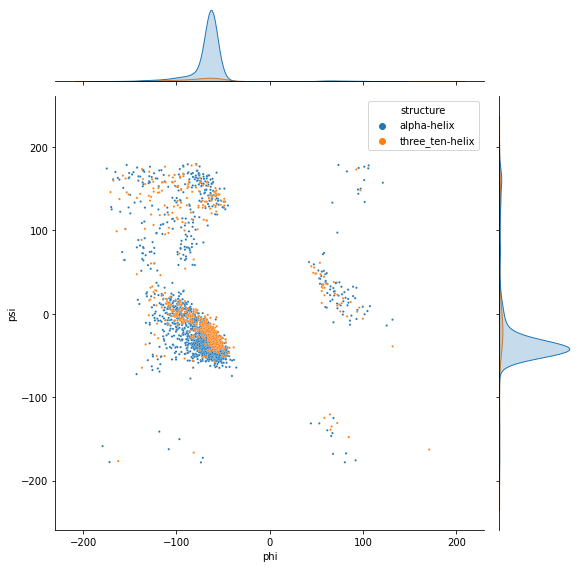

In [26]:
sns.jointplot(x=df_helix['phi'], y=df_helix['psi'], hue=df_helix['structure'], s=5, height=8)